## Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

## Load data

In [3]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

### To tensor

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform=transform
test_dataset.transform=transform

### Split data and create dataloaders

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [6]:
print("Batches in Train Loader: {}".format(len(train_loader)))
print("Batches in Valid Loader: {}".format(len(valid_loader)))
print("Batches in Test Loader: {}".format(len(test_loader)))

print("Examples in Train Loader: {}".format(len(train_loader.sampler)))
print("Examples in Valid Loader: {}".format(len(valid_loader.sampler)))
print("Examples in Test Loader: {}".format(len(test_loader.sampler)))
     

Batches in Train Loader: 375
Batches in Valid Loader: 94
Batches in Test Loader: 79
Examples in Train Loader: 48000
Examples in Valid Loader: 12000
Examples in Test Loader: 10000


## Create CNN

In [7]:
class ConvNet(nn.Module):
    
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
     

### Initialize

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion= nn.CrossEntropyLoss()

### Train

In [10]:
history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
        
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in valid_loader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler)*100
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_acc = val_correct / len(valid_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    history['train_loss'].append(train_loss)    
    history['valid_loss'].append(valid_loss)  
    history['train_acc'].append(train_acc)  
    history['valid_acc'].append(valid_acc)  

Epoch:1/10 	 AVERAGE TL:0.0313 AVERAGE VL:0.0419 	 AVERAGE TA:98.98 %  AVERAGE VA:98.88 %
Epoch:2/10 	 AVERAGE TL:0.0258 AVERAGE VL:0.0442 	 AVERAGE TA:99.14 %  AVERAGE VA:98.86 %
Epoch:3/10 	 AVERAGE TL:0.0261 AVERAGE VL:0.0384 	 AVERAGE TA:99.17 %  AVERAGE VA:99.02 %
Epoch:4/10 	 AVERAGE TL:0.0245 AVERAGE VL:0.0512 	 AVERAGE TA:99.18 %  AVERAGE VA:98.87 %
Epoch:5/10 	 AVERAGE TL:0.0238 AVERAGE VL:0.0422 	 AVERAGE TA:99.20 %  AVERAGE VA:98.99 %
Epoch:6/10 	 AVERAGE TL:0.0222 AVERAGE VL:0.0417 	 AVERAGE TA:99.30 %  AVERAGE VA:98.99 %
Epoch:7/10 	 AVERAGE TL:0.0224 AVERAGE VL:0.0410 	 AVERAGE TA:99.27 %  AVERAGE VA:99.02 %
Epoch:8/10 	 AVERAGE TL:0.0221 AVERAGE VL:0.0410 	 AVERAGE TA:99.25 %  AVERAGE VA:99.08 %
Epoch:9/10 	 AVERAGE TL:0.0204 AVERAGE VL:0.0405 	 AVERAGE TA:99.29 %  AVERAGE VA:99.07 %
Epoch:10/10 	 AVERAGE TL:0.0194 AVERAGE VL:0.0480 	 AVERAGE TA:99.32 %  AVERAGE VA:99.08 %


### Evaluation

In [11]:
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.sampler)

print('Accuracy of the network on the test images: {:.2f} %%'.format(100 * correct / total))
print('Loss of the network on the test images: {:.4f}'.format(test_loss))
     

Accuracy of the network on the test images: 99.14 %%
Loss of the network on the test images: 0.0344


## Visualization

In [12]:
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [16]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([16, 1, 5, 5])
CONV: Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([32, 16, 5, 5])


### First convolution layer

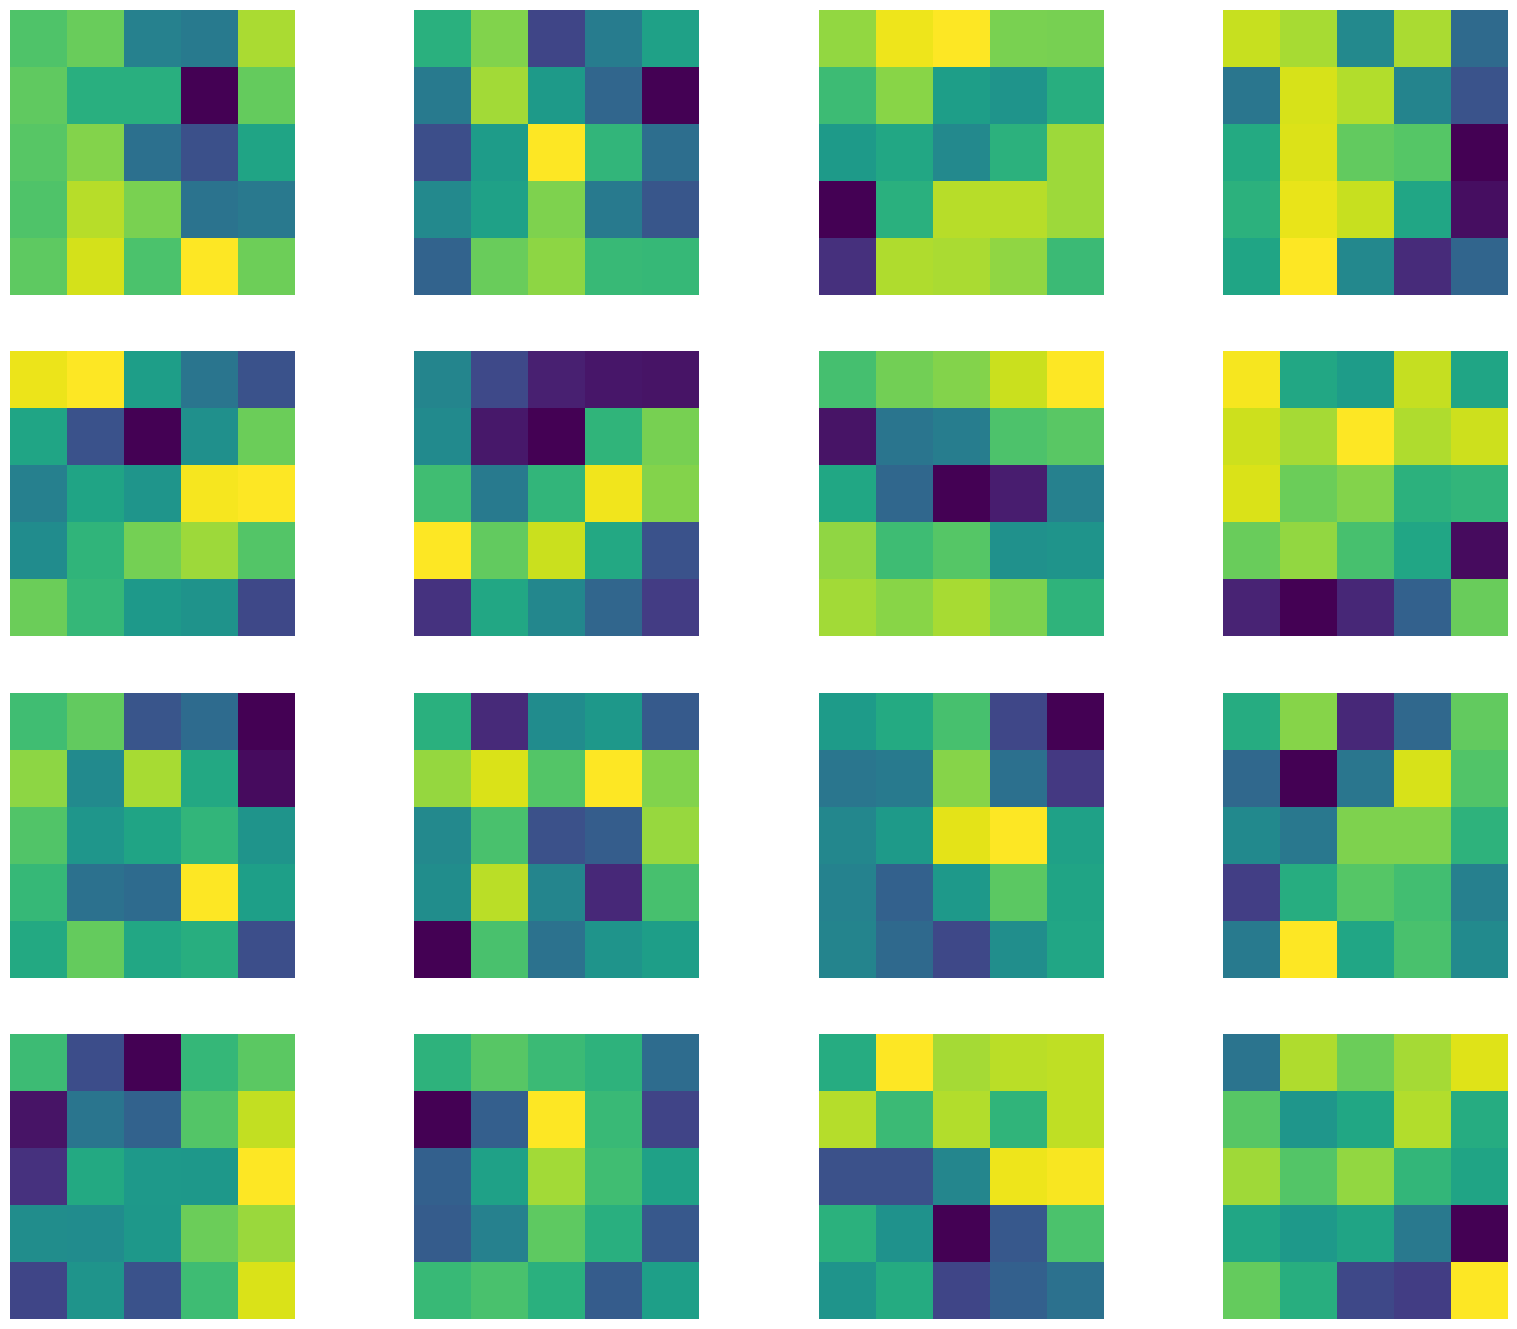

In [17]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

### Second conv layer

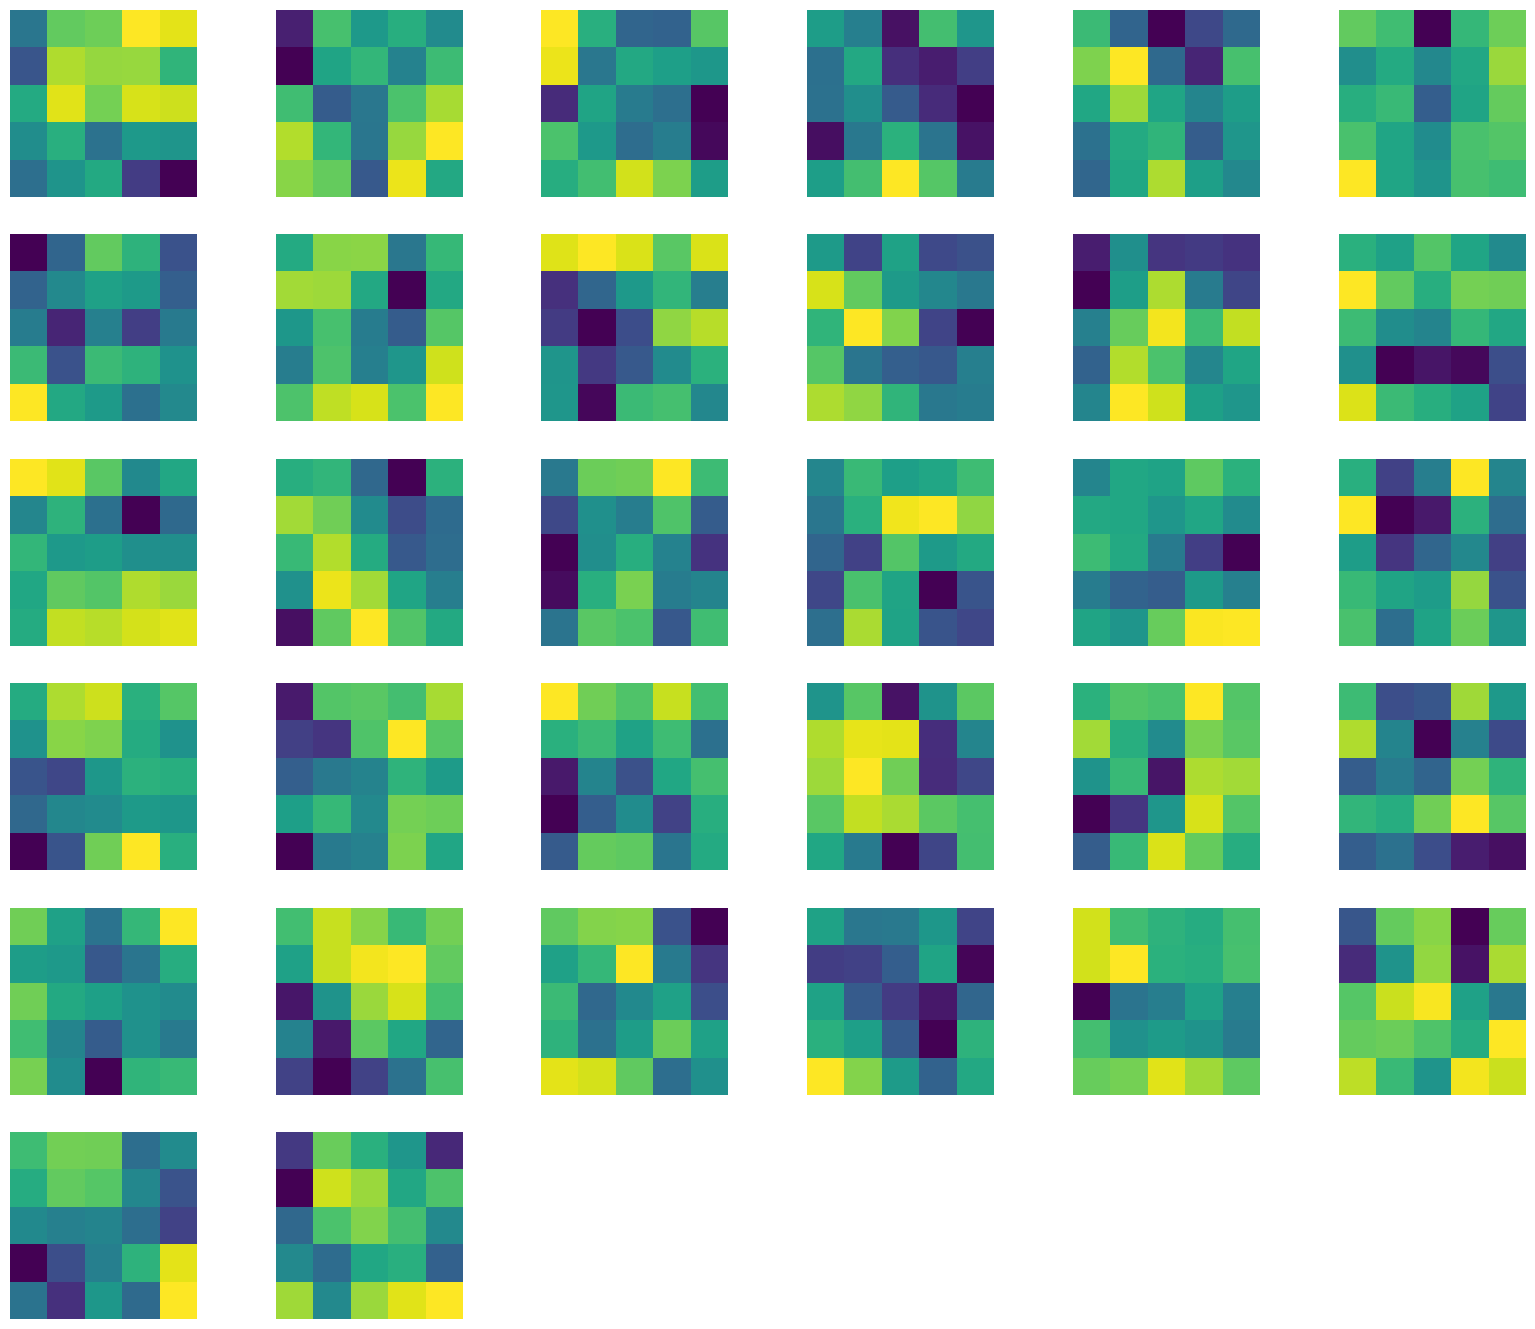

In [18]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

### Feature map over the data

In [19]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

/home/bluterplay/jupyter/pylab/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


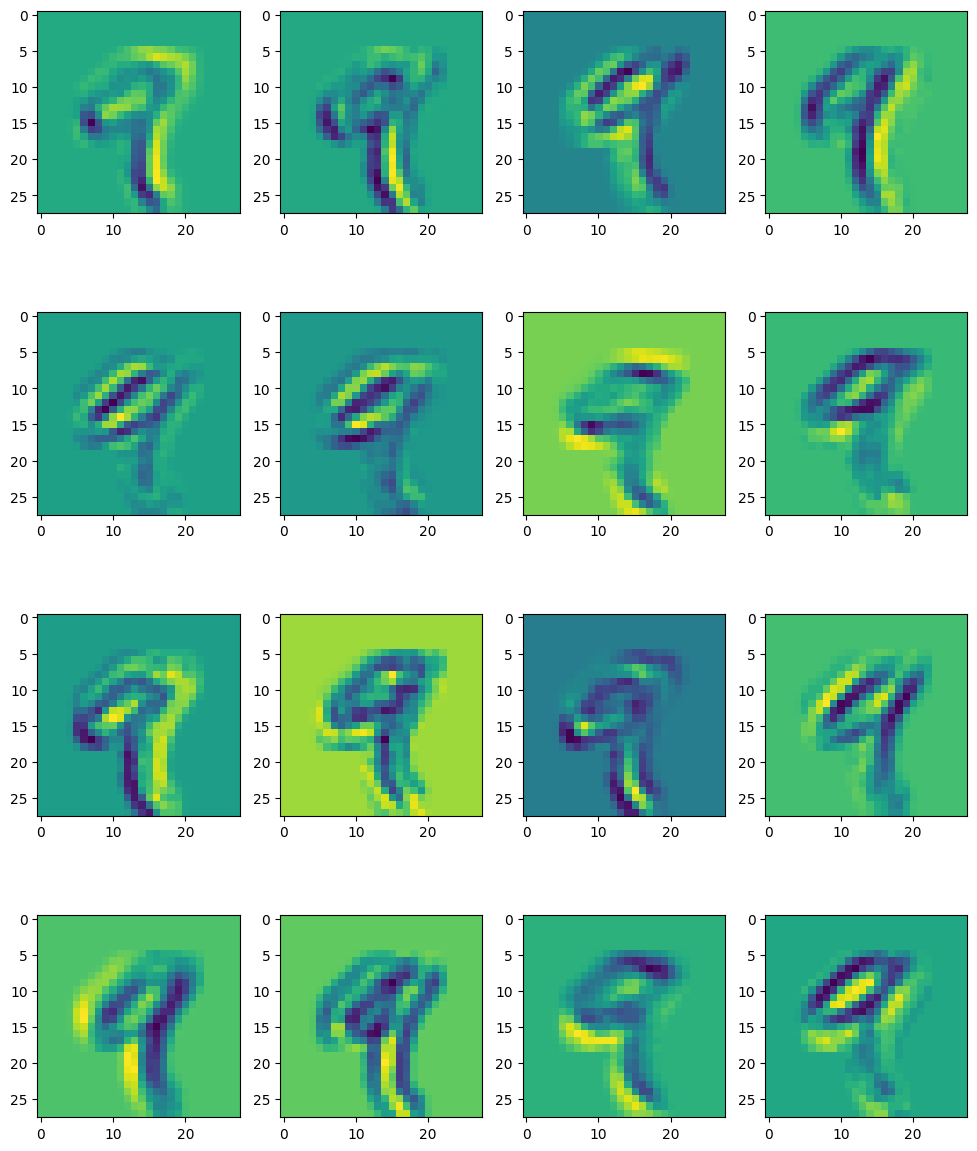

In [20]:
model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(4,4,figsize=(12, 15))

for i in range(act.size(0)//4):
        for j in range(act.size(0)//4):
            ax[i,j].imshow(act[k].detach().cpu().numpy())
            k+=1    
            plt.savefig('fm1.png') 

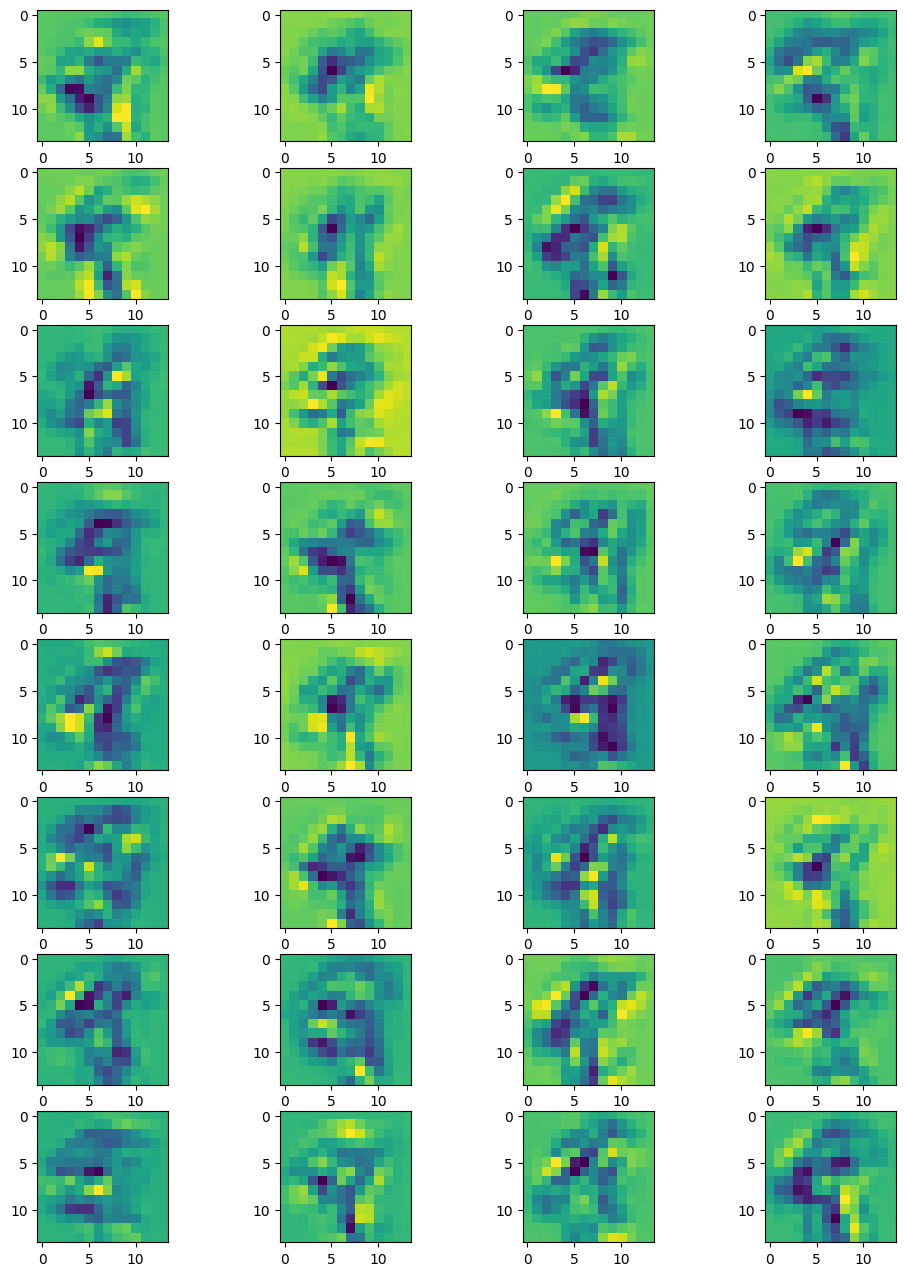

In [21]:
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)
act = activation['conv2'].squeeze()

fig, axarr = plt.subplots(act.size(0)//4,4,figsize=(12, 16))
k=0
for i in range(act.size(0)//4):
        for j in range(4):
            axarr[i,j].imshow(act[k].detach().cpu().numpy())
            k+=1  
            plt.savefig('fm2.png')  